In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk

%matplotlib inline

In [3]:
!iconv -f cp1251 -t utf-8 vk_feed.csv -o vk_feed_utf.csv 

iconv: cannot open input file `vk_feed.csv': No such file or directory


In [4]:
data = pd.read_csv('cleaned_data.csv', index_col=0)
data.head()

,text,status,predict_proba,predict,lang
0,ребят краснодар нужны доноры положительная для...,1,1.0,1,ru
1,волгоград прошу максимальный перепост предыдущ...,1,0.9,1,ru
2,срочно требуются доноры крови любая цельная кр...,1,1.0,1,ru
4,анонимно люди крик о помощи срочно а точнее в ...,1,1.0,1,ru
5,люди крик о помощи срочно а точнее в понедельн...,1,1.0,1,ru


In [5]:
from langdetect import detect

def detect_language(text):
    try:
        lang = detect(text)
        return lang
    except:
        return '-'

In [6]:
data.groupby(by='lang').count()

,text,status,predict_proba,predict
lang,,,,
ru,26108,26108,26108,26108


In [7]:
data = data[data['lang'] == 'ru']

In [8]:
data.groupby(by='status').count()

,text,predict_proba,predict,lang
status,,,,
0,1836,1836,1836,1836
1,24272,24272,24272,24272


In [122]:
import re
from html2text import html2text

def preprocess(text):
    text = html2text(text)
    text = re.sub('[\W]', ' ', text)
    text = re.sub('_', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub('[A-Za-z0-9]', '', text) #removing english
    text = text.lower()
    return text

In [123]:
data['text'] = data['text'].apply(preprocess)

In [139]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem.snowball import RussianStemmer

class Preprocessor:
    def __init__(self, stemmer, analyser):
        self.stemmer = stemmer
        self.analyser = analyser
        
    def __call__(self, doc):
        return (self.stemmer.stem(w) for w in self.analyser(doc) if len(w) > 3)
    
preporcessor = Preprocessor(RussianStemmer(), CountVectorizer(ngram_range=(1,3)).build_analyzer())

vectorizer = CountVectorizer(stop_words=stopwords.words('russian'), analyzer=preporcessor)
V = vectorizer.fit_transform(data['text'])

print(V.shape)

(26108, 557793)


In [140]:
feature_count = len(vectorizer.vocabulary_)

feature_names = [''] * feature_count

for key, value in vectorizer.vocabulary_.items():
    feature_names[int(value)] = key

In [141]:
X = V
y = np.array(data['status'])

In [143]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

kfold = StratifiedKFold(y, n_folds=4, shuffle=True)
rf = RandomForestClassifier(n_estimators=100)
mnb = MultinomialNB(alpha=1)

model = VotingClassifier(estimators=[('rf', rf), ('mnb', mnb)], voting='soft', weights=[3, 1])

for train_index, test_index in kfold:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model.fit(X_train, y_train)
    print(model.score(X_test, y_test))

0.9777845871
0.979623104029


KeyboardInterrupt: 

In [ ]:
model.fit(X, y)

In [101]:
model.score(X, y)

0.99383330779837598

In [102]:
predict_proba = list(map(lambda x: x[1], model.predict_proba(X)))
data['predict_proba'] = predict_proba
data['predict'] = model.predict(X)

In [103]:
data.to_csv('cleaned_data.csv')

In [17]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

y_true = data['status']
fpr, tpr, thresholds = roc_curve(y_true, predict_proba)
auc_score = auc(fpr, tpr)

In [58]:
def plot_roc(fpr, tpr, auc_score):
    plt.figure()
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 0.995])
    plt.ylim([0.995, 1.0])
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.title('ROC Curve. AUC = {0:.5f}'.format(auc_score))
    plt.show()

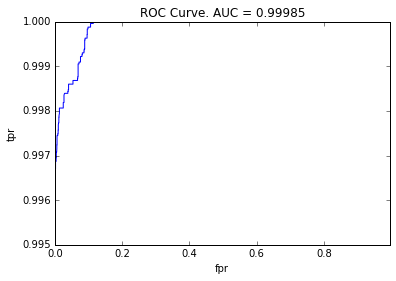

In [59]:
plot_roc(fpr, tpr, auc_score)

In [49]:
from sklearn.metrics import precision_recall_curve

precision, recall, pcrt = precision_recall_curve(y_true, predict_proba)
pcrt = np.insert(pcrt, 0, 0)
pcrt = 1 - pcrt

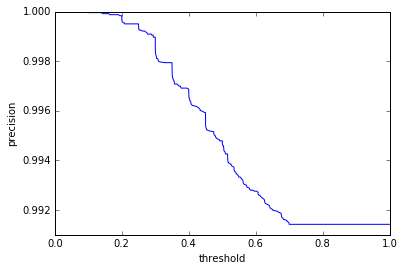

In [50]:
plt.figure()
plt.plot(pcrt, precision)
plt.xlabel('threshold')
plt.ylabel('precision')

(0.9, 1.0)

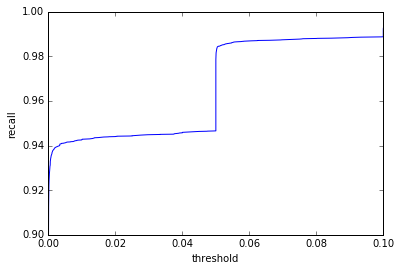

In [57]:
plt.figure()
plt.plot(pcrt, recall)
plt.xlabel('threshold')
plt.ylabel('recall')
plt.xlim([0.0, 0.1])
plt.ylim([0.9, 1.0])

In [46]:
data['predict'] = model.predict(X)
data.to_csv('cleaned_data.csv')

In [47]:
false_negative = data[~data['predict'] & (data['status'] == 1)]
false_negative

,text,status,predict_proba,predict,lang
1991,нужно больше крови,1,0.308333,0,ru
4433,нужна кровь,1,0.328571,0,ru
13250,беременной нужна кровь,1,0.461905,0,ru
18465,поможем ванечке одолеть рак,1,0.400000,0,ru
19071,ребятушки отзовитесь на день кровь из носу нуж...,1,0.500000,0,ru
26301,нужна кровь много,1,0.461905,0,ru


In [48]:
false_positive = data[data['predict'] & (data['status'] == 0)]
false_positive

,text,status,predict_proba,predict,lang
13862,уважаемые участники группы экстренно требуется...,0,0.600000,1,ru
22743,важно нужны доноры анальных тканей для нашего ...,0,0.800000,1,ru
23057,срочно один из жителей приюта нуждается в меди...,0,0.600000,1,ru
23930,внебрачному сыну немцова требуется капля крови...,0,0.600000,1,ru
25454,оксана витковская нужна помощь на огнивке почт...,0,0.700000,1,ru
27540,мы постим всевозможное говно на стене но когда...,0,0.600000,1,ru
27957,сегодня не будет второй операции она должна сн...,0,0.566667,1,ru
29669,нужны доноры ооцитов яйцеклеток в москву возра...,0,0.600000,1,ru
30037,ыздар айырлы к н ыздар срочно донор керек ан т...,0,0.600000,1,ru
32475,срочно требуется донор почки группа крови опла...,0,0.900000,1,ru


In [104]:
from dill import dill

with open('model/voting/vectorizer.pkl', 'wb') as f:
    dill.dump(vectorizer, f)

with open('model/voting/model.pkl', 'wb') as f:
    dill.dump(model, f)